# Word2Vec

In this notebook I will implement a Word2Vec imbedding in order to learn how it works.

Procedure:
1. obtain data 
    - could just use train.csv from Quora
    - could find some other body of text
    - for dictionary, there's the 10,000 words from CS 32 Project 3
2. one-hot encode dictionary
3. set up neural network
4. train neural network
5. obtain embeddings
6. play around with embeddings (e.g. king - man + woman = queen, pig - oink + dog = woof)

keywords:
- continuous bag-of-words model
- skipgram model
- negative sampling


In [30]:
import numpy as np
import pandas as pd
import string
from tqdm import tqdm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import re
import warnings

### Read Data

In [2]:
# Read a list of stopwords
with open('stopwords.txt') as f:
    stopwords = [line.replace('\n', '') 
                 for line in f 
                 if not re.match('^#', line)]
stopwords[:5]

['a', 'about', 'above', 'across', 'after']

In [3]:
with open('a_study_in_scarlet.txt', encoding = 'utf-8') as f:
    text = f.read().replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', '“”'))
    text = ''.join([t for t in text if t not in list('0123456789')])
    text = text.lower().split()

text = [w for w in text if w not in stopwords][1:]
text[:7]

['project', 'gutenberg', 'ebook', 'study', 'scarlet', 'ebook', 'united']

### Prepare Training Data

Negative sampling

In [5]:
WINDOW_SIZE = 3
NUM_NEGATIVE_SAMPLES = 3

data = []

# iterate over all words
for idx, center_word in enumerate(tqdm(text[WINDOW_SIZE - 1 : -WINDOW_SIZE])):

    # list the context words around the center word
    context_words = [context_word
                     for context_word in text[idx : idx + 2 * WINDOW_SIZE - 1]
                     if context_word != center_word]
    
    # for each context word:
    for context_word in context_words:

        # append the context word to data with label 1
        data.append([center_word, context_word, 1])

        # sample NUM_NEGATIVE_SAMPLES words NOT in the current context
        negative_samples = np.random.choice([w 
                                             for w in text[WINDOW_SIZE - 1 : -WINDOW_SIZE]
                                             if w != center_word and w not in context_words],
                                            NUM_NEGATIVE_SAMPLES)
        # and append them to data with label = 0
        for neg_samp in negative_samples:
            data.append([center_word, neg_samp, 0])

100%|██████████| 16777/16777 [03:42<00:00, 75.27it/s]  


In [7]:
df = pd.DataFrame(columns = ['center_word', 'context_word', 'label'], data = data)

# words is an array of unique words present in 
# both df.context_word and df.center_word
words = np.intersect1d(df.context_word, df.center_word)

# drop rows where center word is not a context word
# and where context word is not a center word
#   - this ensures that every word has equal amount of information
df = df[(df.center_word.isin(words)) & 
        (df.context_word.isin(words))].reset_index(drop = True)

In [10]:
df

center_word context_word  label
0            ebook      project      1
1            ebook         life      0
2            ebook     hardship      0
3            ebook         mean      0
4            ebook    gutenberg      1
...            ...          ...    ...
267633       email       puffed      0
267634       email         hear      1
267635       email   mysterious      0
267636       email    intuition      0
267637       email         deal      0

[267638 rows x 3 columns]

### Functions

In [11]:
def sigmoid(v, scale = 1):
    return 1 / (1 + np.exp(-scale * v))

In [12]:
def normalize_data(data):
    row_norms = np.sqrt((data.values**2).sum(axis = 1)).reshape(-1, 1)
    return data.divide(row_norms, axis = 'index')

In [60]:
def plot_words(debug, main_embeddings, context_embeddings):
    plt.figure(figsize = (6, 2))

    plt.subplot(1, 2, 1)
    lim_main_first = main_embeddings.loc[[debug[0]]]
    lim_main_second = main_embeddings.loc[[debug[1]]]
    
    p1 = plt.scatter(lim_main_first[0], lim_main_second[1], color = 'r')
    plt.arrow(0, 0, 
              float(lim_main_first[0]), float(lim_main_first[1]), 
              head_width = 0.01, length_includes_head = True)
    for idx, row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))

    p2 = plt.scatter(lim_main_second[0], lim_main_second[1], color = 'r')
    plt.arrow(0, 0, 
              float(lim_main_second[0]), float(lim_main_second[1]), 
              head_width = 0.01, length_includes_head = True)
    for idx, row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))

    sim = 1 - cosine(main_embeddings.loc[debug[0]], 
                     main_embeddings.loc[debug[1]])
    
    plt.title('Sim = %s'%round(sim, 4), fontsize = 10)
    plt.axvline(0, color = 'k', linestyle = '--', alpha = 0.5)
    plt.axhline(0, color = 'k', linestyle = '--', alpha = 0.5)

    t = np.arange(0, 3.14 * 2 + 0.1, 0.1)
    plt.plot(np.cos(t), np.sin(t),
             linewidth = 1, color = 'k', alpha = 0.5, linestyle = '--')

    ##########

    plt.subplot(1, 2, 2)
    lim_main = main_embeddings.loc[[debug[0]]]
    lim_context = context_embeddings.loc[[debug[1]]]
    
    p1 = plt.scatter(lim_main[0], lim_main[1], color = 'r')
    plt.arrow(0, 0, 
              float(lim_main[0]), float(lim_main[1]), 
              head_width = 0.01, length_includes_head = True)
    for idx, row in lim_main.iterrows():
        plt.text(row[0], row[1], str(idx))

    p2 = plt.scatter(lim_context[0], lim_context[1], color = 'b')
    plt.arrow(0, 0, 
              float(lim_context[0]), float(lim_context[1]), 
              head_width = 0.01, length_includes_head = True)
    for idx, row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))

    sim = 1 - cosine(main_embeddings.loc[debug[0]], 
                     main_embeddings.loc[debug[1]])
    
    plt.title('Sim = %s'%round(sim, 4), fontsize = 10)
    plt.axvline(0, color = 'k', linestyle = '--', alpha = 0.5)
    plt.axhline(0, color = 'k', linestyle = '--', alpha = 0.5)

    plt.plot(np.cos(t), np.sin(t),
             linewidth = 1, color = 'k', alpha = 0.5, linestyle = '--')
    
    plt.show()

In [57]:
def update_embeddings(df, 
                      main_embeddings, 
                      context_embeddings, 
                      learning_rate, 
                      debug = False):
    
    # get differences between main and corresponding context embeddings
    main_embeddings_center = main_embeddings.loc[df.center_word].values
    context_embeddings_context = context_embeddings.loc[df.context_word].values
    diffs = context_embeddings_context - main_embeddings_center

    # get similarities, scores, and errors
    # between main and corresponding context embeddings
    dot_prods = np.sum(main_embeddings_center * context_embeddings_context, 
                       axis = 1)
    scores = sigmoid(dot_prods)
    errors = (df.label - scores).values.reshape(-1, 1)

    # calculate updates
    updates = diffs * errors * learning_rate
    updates_df = pd.DataFrame(data = updates)
    updates_df['center_word'] = df.center_word
    updates_df['context_word'] = df.context_word
    updates_df_center = updates_df.groupby('center_word').sum()
    updates_df_context = updates_df.groupby('context_word').sum()

    if debug:
        plot_words(debug, main_embeddings, context_embeddings)

    # apply updates
    main_embeddings += updates_df_center.loc[main_embeddings.index]
    context_embeddings -= updates_df_context.loc[context_embeddings.index]

    # normalize embeddings
    main_embeddings = normalize_data(main_embeddings)
    context_embeddings = normalize_data(context_embeddings)

    # return the updates embeddings
    return main_embeddings, context_embeddings


### Run Word2Vec

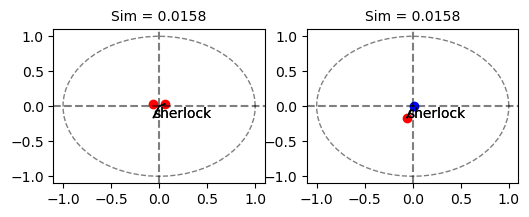

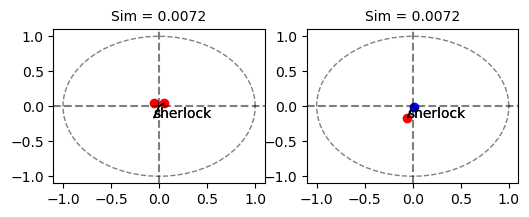

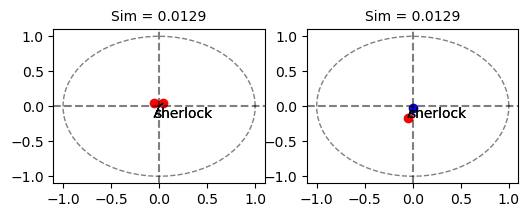

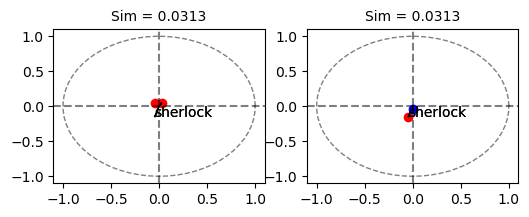

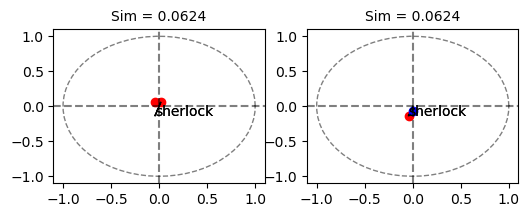

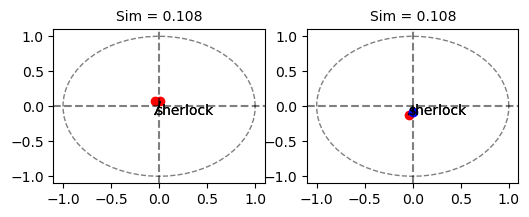

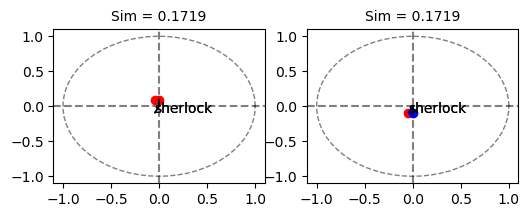

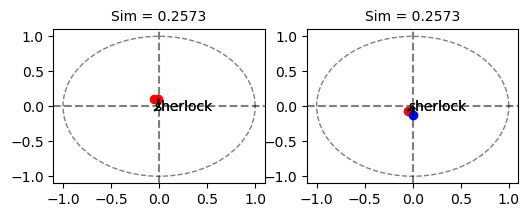

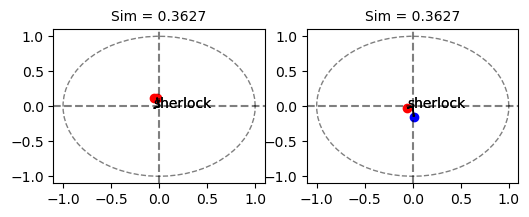

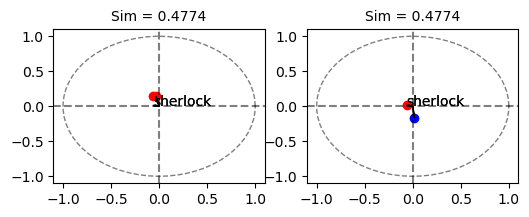

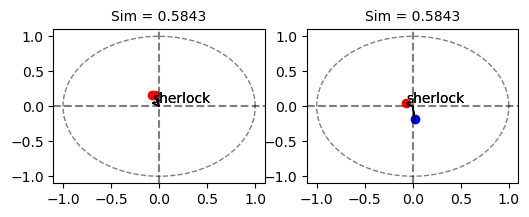

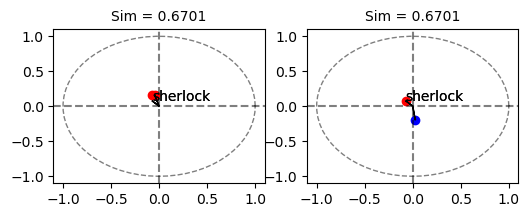

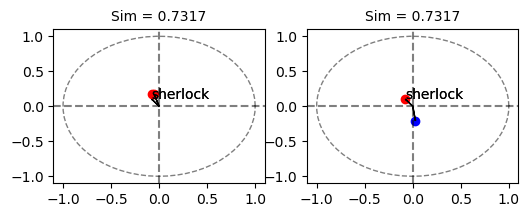

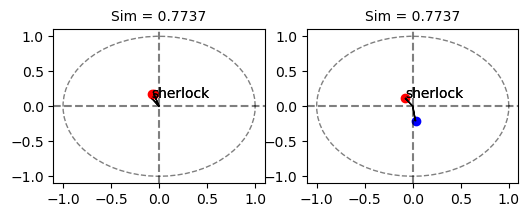

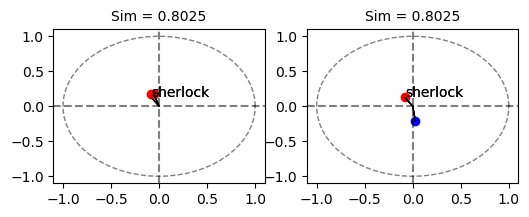

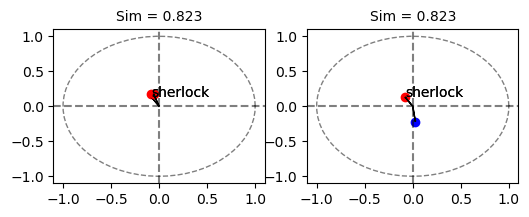

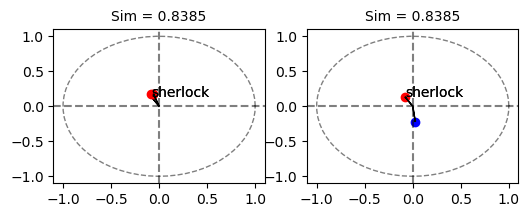

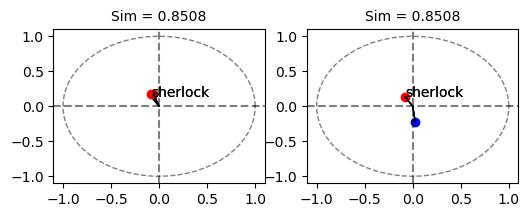

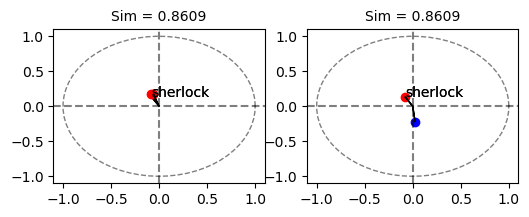

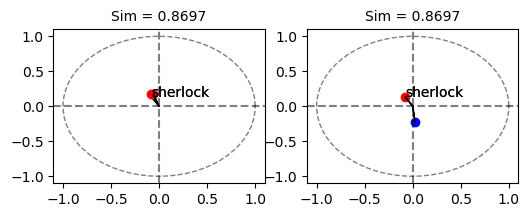

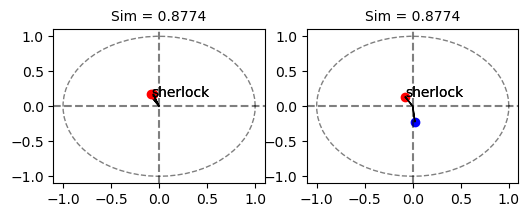

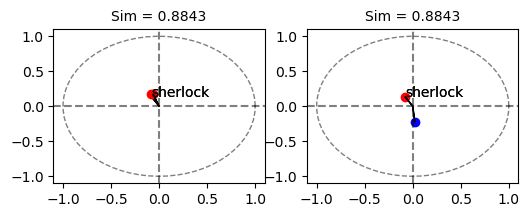

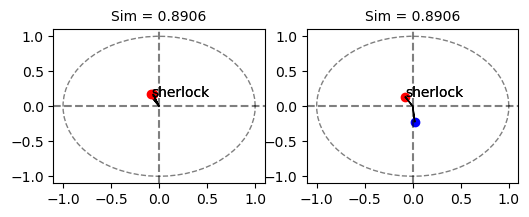

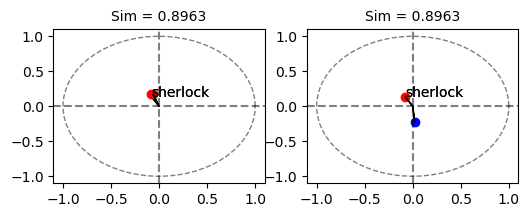

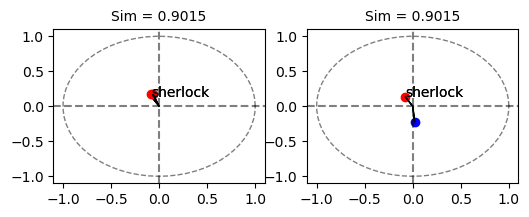

In [61]:
EMBEDDING_SIZE = 100

main_embeddings = np.random.normal(0, 0.1, (len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((main_embeddings**2).sum(axis = 1)).reshape(-1, 1)
main_embeddings = main_embeddings / row_norms

context_embeddings = np.random.normal(0, 0.1, (len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((context_embeddings**2).sum(axis = 1)).reshape(-1, 1)
context_embeddings = context_embeddings / row_norms

main_embeddings = pd.DataFrame(data = main_embeddings, index = words)
context_embeddings = pd.DataFrame(data = context_embeddings, index = words)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for _ in range(25):
        main_embeddings, context_embeddings = update_embeddings(df,
            main_embeddings,
            context_embeddings,
            0.1,
            ['sherlock', 'holmes'])

In [62]:
L = [(w1, w2, 1 - cosine(main_embeddings.loc[w1], main_embeddings.loc[w2]))
     for w1 in tqdm(words)
     for w2 in words
     if w1 != w2]
sorted([item for item in L if item[0] == 'sherlock'],
       key = lambda t : -t[2])[:10]

100%|██████████| 5958/5958 [1:09:24<00:00,  1.43it/s]   


[('sherlock', 'holmes', 0.9063785904078797),
 ('sherlock', 'remarked', 0.8448252950883645),
 ('sherlock', 'metal', 0.8311659233960578),
 ('sherlock', 'sharply', 0.8249702708276022),
 ('sherlock', 'laugh', 0.8221141736332069),
 ('sherlock', 'otherwise', 0.8152781644987861),
 ('sherlock', 'stair', 0.8148765453550777),
 ('sherlock', 'cab', 0.8123769109243794),
 ('sherlock', 'descended', 0.8097659926459945),
 ('sherlock', 'importance', 0.8047850004071133)]

In [68]:
def top_n_words(word, n = 10):
       return sorted([item for item in L if item[0] == word], 
                     key = lambda t : -t[2])[:n]

In [75]:
top_n_words('detective')

[('detective', 'lestrade', 0.8496451410553644),
 ('detective', 'gregson', 0.8372053724065014),
 ('detective', 'appears', 0.8270856457626298),
 ('detective', 'allusion', 0.8264699112118283),
 ('detective', 'murder', 0.8233897196895579),
 ('detective', 'listened', 0.819916433272923),
 ('detective', 'head', 0.8120604430900001),
 ('detective', 'fellow', 0.8111209469633412),
 ('detective', 'stairs', 0.8110988193638037),
 ('detective', 'girl', 0.8096463553807524)]

In [46]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA(n_components = 2)
transf_embeddings = pca.fit_transform(main_embeddings.values)
words_used = main_embeddings.index

In [51]:
plt.figure(figsize = (100, 100))
plt.scatter(transf_embeddings[:, 0], transf_embeddings[:, 1])
for idx, row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))
plt.axvline(0, color = 'k', linestyle = '--', alpha = 0.5)
plt.axhline(0, color = 'k', linestyle = '--', alpha = 0.5)